#Part 0

## Install Packages & Data

In [98]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from sklearn.kernel_ridge import KernelRidge
from sklearn.preprocessing import StandardScaler
from numpy.random import default_rng
from sklearn.model_selection import GridSearchCV, cross_val_score, KFold
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
from scipy.interpolate import griddata

Import Data.

In [11]:
path_data = 'data.csv' #edit path as necessary

# Check if files exist before loading
if os.path.exists(path_data):
    data = pd.read_csv(path_data)
    print("Data loaded successfully.")
else:
    print("Error: One or both files not found. Check the file paths.")

y = data.loc[:,'ViolentCrimesPerPop']
X = data.loc[:, data.columns != 'ViolentCrimesPerPop']

Data loaded successfully.


## Split Data

In [12]:
scaler = StandardScaler(with_mean=True, with_std=True)
X_standardized = scaler.fit_transform(X) #Standardize X (centered and scaled)
colnames = X.columns #Feature names

In [13]:
rng = default_rng(1) #Set a random seed

train_prop = 0.6
validation_prop = 0.2
test_prop = 0.2

# Calculate the number of observations for each split
total_samples = data.shape[0]
train_size = int(train_prop * total_samples)
validation_size = int(validation_prop * total_samples)
test_size = total_samples - train_size - validation_size

# Create a random permutation of row indices
indices = rng.choice(np.arange(total_samples), size=(total_samples), replace=False)

# Split the dataset into train, validation, and test sets
y_train = y[indices[:train_size]]
y_val = y[indices[(train_size + 1):(train_size + validation_size)]]
y_test = y[indices[(train_size + validation_size + 1):]]

X_train = X_standardized[indices[:train_size]]
X_val = X_standardized[indices[(train_size + 1):(train_size + validation_size)]]
X_test = X_standardized[indices[(train_size + validation_size + 1):]]

# Part A

In [14]:
# Combine validation and train sets into one (we don't need the validation set anymore).
X_train = np.vstack((X_train, X_val))
y_train = np.concatenate((y_train, y_val))

## RBF Ridge

First I define a function that performs Cross Validation Radial Basis Function (RBF) kernel ridge for fixed hyperparameters $\alpha$ and $\gamma$.  I will use this function to then iterate over all combinations of $\alpha$ and $\gamma$ and select the hyperparameters that minimize the average MSE across all folds.

In [16]:
def CV_rbf(alpha_, gamma_, n_folds = 5, X_train_ = X_train, y_train_ = y_train):
  #define the rbf model
  rbf = KernelRidge(alpha=alpha, kernel='rbf', gamma=gamma)

  cv_mse = []
  kf = KFold(n_splits=5, shuffle=True, random_state=42)
  #this will look n_splits = k times.
  #splits is a tuple with (X_train, X_validate) and will shift every time according to CV.
  for splits in kf.split(X_train):
    train_index = splits[0] #our training index
    val_index = splits[1] #our validation index

    #now we define our data using the CV index method.
    Xtrain = X_train[train_index]
    Xval = X_train[val_index]

    ytrain = y_train[train_index]
    yval = y_train[val_index]

    #now we have to fit the model and evaluate mse based on each fold and each combination of alpha and gamma
    rbf.fit(Xtrain, ytrain)
    ypred = rbf.predict(Xval)
    mse = mean_squared_error(yval, ypred)
    cv_mse.append(mse)

  cv_mse = np.array(cv_mse)
  avg_mse = np.mean(cv_mse)
  return avg_mse

Now to implement the above function and iterate over all hyperparameters.

In [54]:
def rbf_manual_cv(alpha_num = 10, gamma_num = 10): #increase these numbers for better accuracy but longer computational time

  def CV_rbf(alpha_, gamma_, n_folds = 5, X_train_ = X_train, y_train_ = y_train):
    #define the rbf model
    rbf = KernelRidge(alpha=alpha, kernel='rbf', gamma=gamma)

    cv_mse = []
    kf = KFold(n_splits=n_folds, shuffle=True, random_state=42)
    #this will look n_splits = k times.
    #splits is a tuple with (X_train, X_validate) and will shift every time according to CV.
    for splits in kf.split(X_train):
      train_index = splits[0] #our training index
      val_index = splits[1] #our validation index

      #now we define our data using the CV index method.
      Xtrain = X_train[train_index]
      Xval = X_train[val_index]

      ytrain = y_train[train_index]
      yval = y_train[val_index]

      #now we have to fit the model and evaluate mse based on each fold and each combination of alpha and gamma
      rbf.fit(Xtrain, ytrain)
      ypred = rbf.predict(Xval)
      mse = mean_squared_error(yval, ypred)
      cv_mse.append(mse)

    cv_mse = np.array(cv_mse)
    avg_mse = np.mean(cv_mse)
    return avg_mse

  results = {'alpha': [], 'gamma': [], 'avg_mse_cv': []}

  alpha_values = 10 ** np.linspace(-2, 0.5, num=alpha_num) #change to make array larger if computation time allows
  gamma_values = 10 ** np.linspace(-2, 0.5, num=gamma_num)

  #initialize the parameters
  best_alpha = None
  best_gamma = None
  best_mse = float('inf')

  # Loop through all combinations of alpha and gamma to determine the best combination
  for alpha in alpha_values:
      for gamma in gamma_values:
        results['alpha'].append(alpha)
        results['gamma'].append(gamma)
        mse = CV_rbf(alpha_ = alpha, gamma_ = gamma, n_folds = 5)
        results['avg_mse_cv'].append(mse)

        if mse < best_mse: # Checking if the current mse is the lowest
          best_mse = mse
          best_alpha = alpha
          best_gamma = gamma

  tuned = {'best_alpha':best_alpha,
         'best_gamma':best_gamma,
         'lowest_avg_mse': best_mse
  }

  return {'results':tuned, 'all_combinations':results}

Below we run the function rbf_manual_cv and graph the results of this hyperparameter tuning.

In [47]:
function_call = rbf_manual_cv()

In [53]:
best_results = function_call['results']
print(best_results)

{'best_alpha': 0.464158883361278, 'best_gamma': 0.01, 'lowest_avg_mse': 0.02036933895032223}


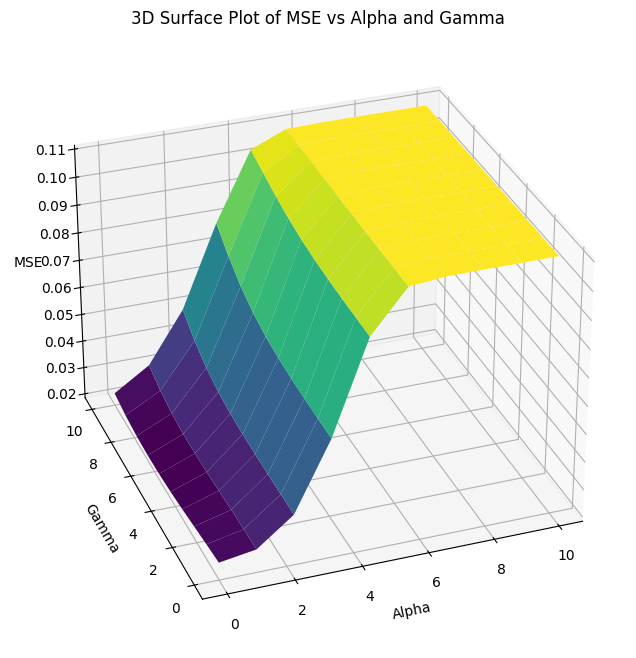

In [49]:
results = function_call['all_combinations']
alpha_values = np.array(results['alpha'])
gamma_values = np.array(results['gamma'])
mse_values = np.array(results['avg_mse_cv'])
alpha_grid, gamma_grid = np.meshgrid(np.linspace(0.001, 10, 10), np.linspace(0.001, 10, 10))
mse_grid = mse_values.reshape(alpha_grid.shape)

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(alpha_grid, gamma_grid, mse_grid, cmap='viridis', edgecolor='none')
ax.view_init(elev=30, azim=-110)  # Change the azim value to rotate horizontally
ax.set_xlabel('Alpha')
ax.set_ylabel('Gamma')
ax.set_zlabel('MSE')
ax.set_title('3D Surface Plot of MSE vs Alpha and Gamma')
plt.show()

We can adjust the hyperparameter tuning to restrict to smaller values of $\alpha$ and $\gamma$ and rerun to increase accuracy (if we make the array of alpha contain more values the computational time will increase, therefore it is preferable to just find ranges where MSE has sharp decline and remove these from consideration).  This is left for future work, and I will now begin working on implementing polynomial kernel ridge regression into the same function.

## Poly Kernel Ridge

Now to write our code for manual cross validation for polynomial kernel ridge.

In [109]:
def poly_kernel_ridge_manual_cv(alpha_num=20, degree_num=3, coef0_num=3):
    def CV_poly_kernel_ridge(alpha_, degree_, coef0_=0, n_folds=5, X_train_=X_train, y_train_=y_train): #coef0_=0 because the data is already centered and standardized
        poly_ridge = KernelRidge(alpha=alpha_, kernel='polynomial', degree=degree_) # Changed to Polynomial Kernel Ridge
        cv_mse = []
        kf = KFold(n_splits=n_folds, shuffle=True, random_state=42)
        for splits in kf.split(X_train):
            train_index = splits[0]
            val_index = splits[1]

            Xtrain = X_train[train_index]
            Xval = X_train[val_index]

            ytrain = y_train[train_index]
            yval = y_train[val_index]

            poly_ridge.fit(Xtrain, ytrain)
            ypred = poly_ridge.predict(Xval)
            mse = mean_squared_error(yval, ypred)
            cv_mse.append(mse)

        cv_mse = np.array(cv_mse)
        avg_mse = np.mean(cv_mse)
        return avg_mse

    results = {'alpha': [], 'degree': [], 'coef0': [], 'avg_mse_cv': []}

    alpha_values = 10 ** np.linspace(-2, 0.5, num=alpha_num)
    degree_values = np.arange(1, degree_num + 1)  # 1 to degree_num

    best_alpha = None
    best_degree = None
    best_coef0 = None
    best_mse = float('inf')

    # Loop through all combinations of alpha ; degree
    for alpha in alpha_values:
        for degree in degree_values:
              results['alpha'].append(alpha)
              results['degree'].append(degree)

              mse = CV_poly_kernel_ridge(alpha_=alpha, degree_=degree, n_folds=5)
              results['avg_mse_cv'].append(mse)

              if mse < best_mse:
                  best_mse = mse
                  best_alpha = alpha
                  best_degree = degree

    tuned = {
        'best_alpha': best_alpha,
        'best_degree': best_degree,
        'lowest_avg_mse': best_mse
    }

    return {'results': tuned, 'all_combinations': results}

In [110]:
function_call_poly = poly_kernel_ridge_manual_cv()

In [111]:
best_results_poly = function_call_poly['results']
print(best_results_poly)

{'best_alpha': 3.1622776601683795, 'best_degree': 2, 'lowest_avg_mse': 0.017697826904654296}


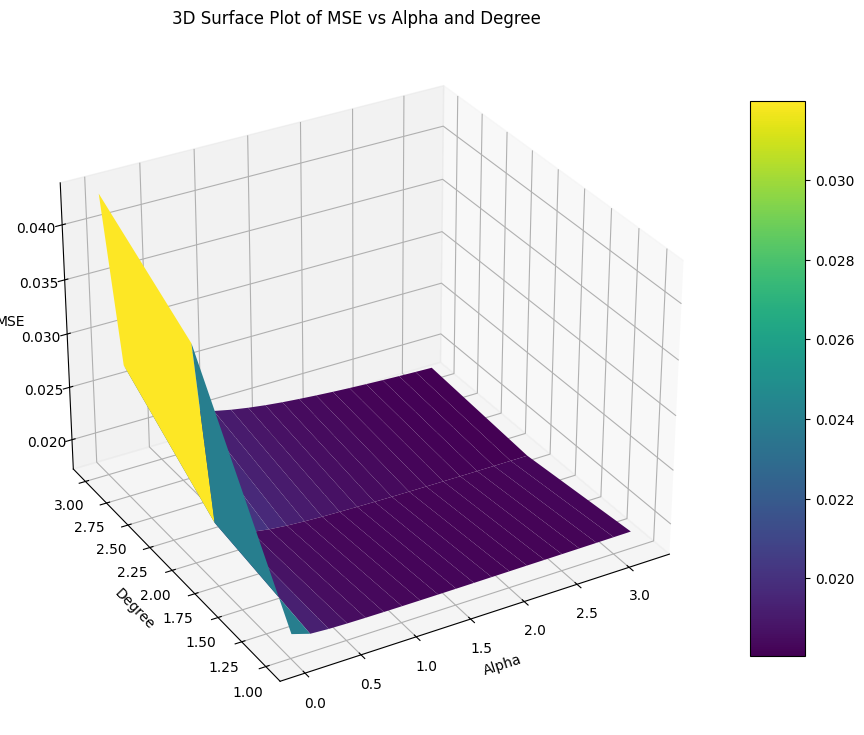

In [112]:
results = function_call_poly['all_combinations']
alpha_values = np.array(results['alpha'])
degree_values = np.array(results['degree'])
mse_values = np.array(results['avg_mse_cv'])

df = pd.DataFrame({
    'alpha': alpha_values,
    'degree': degree_values,
    'mse': mse_values
})

pivot_df = df.groupby(['alpha', 'degree'])['mse'].min().reset_index()
unique_alphas = np.linspace(alpha_values.min(), alpha_values.max(), 20)
unique_degrees = np.unique(degree_values)
alpha_grid, degree_grid = np.meshgrid(unique_alphas, unique_degrees)
mse_grid = griddata((pivot_df['alpha'], pivot_df['degree']),
                    pivot_df['mse'],
                    (alpha_grid, degree_grid),
                    method='cubic')

# Plot
fig = plt.figure(figsize=(12, 9))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(alpha_grid, degree_grid, mse_grid, cmap='viridis', edgecolor='none')
ax.view_init(elev=30, azim=-120)
ax.set_xlabel('Alpha')
ax.set_ylabel('Degree')
ax.set_zlabel('MSE')
ax.set_title('3D Surface Plot of MSE vs Alpha and Degree')
plt.colorbar(surf, shrink=0.8, aspect=10)
plt.show()

## Final Function

Now to finish the function, we will combine these two methods into one and allow for specification.  This function can be used in future projects.

In [114]:
def final_function_parta(method): #method takes values rbf and poly
  if method == 'poly':
    return poly_kernel_ridge_manual_cv(alpha_num=20, degree_num=3, coef0_num=3)
  elif method == 'rbf':
    return rbf_manual_cv(alpha_num = 10, gamma_num = 10)
  else:
    return print('Error: method only takes values "rbf" and "poly"')

Test the function and store values in test1 & test2 for part B.

In [82]:
test1 = final_function_parta('rbf')

In [115]:
test2 = final_function_parta('poly')

In [96]:
test3 = final_function_parta('error')

Error: method only takes values "rbf" and "poly"


# Part B

Now to compare my manual cross validation functions to the packages in sklearn.

In [105]:
def sklearn_kernel_ridge_cv(X_train=X_train, y_train=y_train, kernel='rbf', n_fold=5): # Sklearn Built-in Cross-Validation Function
    if kernel == 'rbf':
        param_grid = {
            'alpha': 10 ** np.linspace(-2, 0.5, 10),
            'gamma': 10 ** np.linspace(-2, 0.5, 10)
        }
    elif kernel == 'poly':  # polynomial
        param_grid = {
            'alpha': 10 ** np.linspace(-2, 0.5, 10),
            'degree': range(1, 4),
            'coef0': [0.0]
        }
    else:
      return print('Error: kernel input does note exist')

    kr = KernelRidge(kernel=kernel)
    grid_search = GridSearchCV(kr, param_grid, cv=n_fold, scoring='neg_mean_squared_error')
    grid_search.fit(X_train, y_train)

    return grid_search.best_params_, -grid_search.best_score_

We have already run the functions in partA and stored them in test1, test2 which correspond to methods 'rbf' and 'poly' respectively.

**Radial Basis Function (RBF) Ridge Regression:**

In [104]:
test1['results']

{'best_alpha': 0.464158883361278,
 'best_gamma': 0.01,
 'lowest_avg_mse': 0.02036933895032223}

In [106]:
sklearn_kernel_ridge_cv(kernel='rbf')

({'alpha': 0.464158883361278, 'gamma': 0.01}, 0.01963526215515035)

✅ The results of the hyperparameter tuning are exactly the same!

**Polynomial Kernel Ridge Regression:**

In [129]:
test2['results']

{'best_alpha': 3.1622776601683795,
 'best_degree': 2,
 'lowest_avg_mse': 0.017697826904654296}

In [117]:
sklearn_kernel_ridge_cv(kernel='poly')

({'alpha': 0.464158883361278, 'coef0': 0.0, 'degree': 2}, 0.027703963270160177)

Here the results for alpha differ a bit.  I did not report coef0 in my function because I will always center and standardize my data defore feeding it into the function and thus this parameter is not necessary to hyperparameter tune (this method reduces the amount of coding required to create the manual package).  The alpha values can differ due to the sophistication techniques used in Sklearns GridSearchCV method.  But overall, the degree parameter is correct and coef0 =0 is correct so this manual implementation is adequate.

# Part C

Now to find the final MSE of the RBF and Poly methods by fitting the optimal parameters for each method that we just found by CV and evaluating MSE on the test set.

In [123]:
#use these untouched testing sets
X_test;
y_test;

In [126]:
best_alpha, best_gamma = test1['results']['best_alpha'], test1['results']['best_gamma']
rbf = KernelRidge(alpha=best_alpha, gamma=best_gamma, kernel='rbf')
rbf.fit(X_train, y_train)
ypred = rbf.predict(X_test)
rbf_mse = mean_squared_error(y_test, ypred)
print(f'RBF mse (after hyperparameter tuning and fitting on test set) = {rbf_mse:.6f}')

RBF mse (after hyperparameter tuning and fitting on test set) = 0.024136


In [130]:
best_alpha_poly, best_degree = test2['results']['best_alpha'], test2['results']['best_degree']
poly_ridge = KernelRidge(alpha=best_alpha_poly, kernel='polynomial', degree=best_degree)
poly_ridge.fit(X_train, y_train)
ypred = poly_ridge.predict(X_test)
poly_mse = mean_squared_error(y_test, ypred)
print(f'Poly mse (after hyperparameter tuning and fitting on test set) = {poly_mse:.6f}')

Poly mse (after hyperparameter tuning and fitting on test set) = 0.019549


Below is the MSE across linear methods from notebook 3 - [3_HyperparameterTuning&Eval.ipynb](https://github.com/dimitris-markopoulos/CrimePredictor-ML/blob/main/3_HyperparameterTuning%26Eval.ipynb)

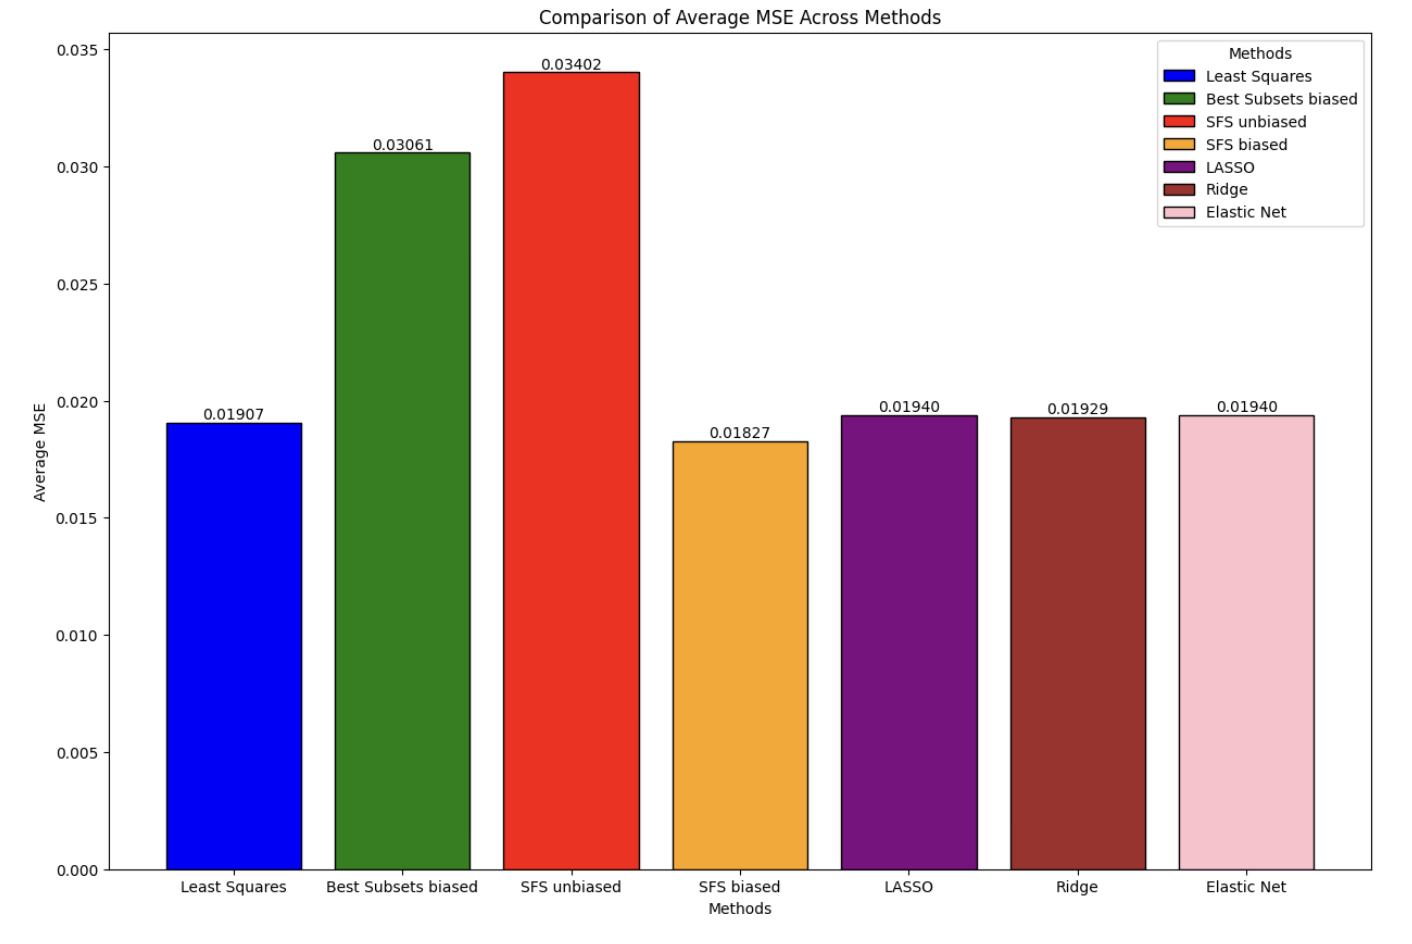

If we look at the MSE across the linear methods we have done, RBF Ridge and Polynomial Kernel Ridge Regression perform well with polynomial performing better then RBF.  However, I would not say that they outperform LASSO, Ridge, or Elastic Net, but there is definitely increased flexibility in this non-linear method.